In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt

%matplotlib inline 


import random

In [2]:
class RBF_Net(object):
    def __init__(self):
        return 
        
    def fit(self, X_train, Y_train, C):
        self.X = X_train
        self.Y = Y_train.T
        self.C = C
        
        self.d = self.d_constr(self.C)
        self.F = self.F_constr(self.X, self.C, self.d)
        self.Wb = self.train(self.Y, self.F)
        
        self.y_dim = len(Y_train[0])
        self.x_dim = len(X_train[0])
        del self.X
        del self.Y

    def d_constr(self, C):
        N = len(C)
        d = np.zeros(N)
        l = np.zeros(N)
        
        for i in tqdm(range(N),"Distant progress"):
            for j in range(N):
                l[j] = np.linalg.norm(C[i] - C[j])
            #d[i] = np.std(l)
            d[i] = np.amin(l) + (np.amax(l) - np.amin(l)) * 0.1
        return d

    def F_constr(self, X, C, d):
        S = len(X)
        N = len(C)
        
        F = np.zeros((N, S))
        for i in tqdm(range(N),"F progress"):
            for j in range(S):
                F[i][j] = np.linalg.norm(X[j] - C[i])
            F[i] = F[i] / d[i]
        F = np.exp(-(F ** 2))
        return F
    
    def FA_const(self, F):
        a = np.ones((1, len(F[0])))
        return np.vstack((F, a))
        
    def train(self, Y, F):
        FA = self.FA_const(F)
        
        FAFAT =tf.linalg.matmul(FA, FA, transpose_b=True)

        self.mu = np.linalg.cond(tf.make_ndarray(tf.make_tensor_proto(FAFAT)))
        FAFAT = tf.linalg.pinv(FAFAT, rcond = 10**(-100), validate_args = True)
        
        Wb =  tf.linalg.matmul(Y, FA, transpose_b=True)
        Wb =  tf.linalg.matmul(Wb, FAFAT)
        
        Wb = tf.make_tensor_proto(Wb)
        Wb = tf.make_ndarray(Wb)
        
        print('Train complete')
        
        return Wb
        
    def predict(self, X):
        F = self.F_constr(X, self.C, self.d)
        FA = self.FA_const(F)
        Y_pr = np.dot(self.Wb, FA)
        return Y_pr.T       
    pass

In [3]:
def weighting(X, func_type, angl):
    
    N = len(X[0])
    k = (angl[1] - angl[0]) / (N - 1)
    
    angles_pi = np.zeros(N)
    angles = np.zeros(N)
    
    
    for i in range(N):
        angles_pi[i] = (angl[0] + k * i ) * np.pi / 180
        angles[i] = angl[0] + k * i
        
    if func_type == 'sin':
        weight = np.sin(angles_pi[i])
        return X*weight

    if func_type == 'sin^2':
        weight = np.sin(angles_pi[i]) ** 2
        return X*weight

    if func_type == 'sin^4':
        weight = np.sin(angles_pi[i]) ** 4
        return X*weight

    if func_type == 'log':
        return np.log(X)

    if func_type == 'm_func':
        weight = np.copy(angles)
        for i in range(len(angles)):
            if angles[i] == 0:
                weight[i] = 0
            if (angles[i] > 0):
                weight[i] = (np.exp(-2*(np.log(angles[i]/54.0))**2))/angles[i]
        #plt.plot(weight)
        return X * weight

def cutter(X, start, end):
    return X[:,start:end+1]

In [4]:
def predict_plot(y_test, y_pred, params):
    N = len(params)
    
    plt.figure(figsize=(20,20))
    
    for i in range (N):
        for j in range(N):
            plt.subplot(N, N, i*N+j+1)

            plt.title("Предсказание с помощью сетей")
            plt.xlabel(params[i])
            plt.ylabel(params[j])

            plt.plot(y_test[:,i], y_test[:,j] ,'*', label = "Тест")
            plt.plot(y_pred[:,i], y_pred[:,j], '.', label = "Предсказание")
            plt.legend()


def error_plot(y_test, y_pred, params):
    
    N = len(params)
    
    error = []
    for j in range(len(y_pred[0])):
        buf_err = []    
        for i in range(len(y_pred)):
            buf_err.append((y_test[i,j]-y_pred[i,j]))   
        error.append(buf_err)


    plt.figure(figsize=(20,20))
    
    for i in range (N):
        
        plt.subplot(N, 2, i*2+1)
        plt.title("Ошибка предсказания %s" %(params[i]))
        plt.ylabel("Ошибка предсказания %s" %(params[i]))
        plt.xlabel("Номер индикатрисы")
        plt.plot(error[i],'*')
        
    
        plt.subplot(N, 2, i*2+2)
        plt.title("Распределение ошибки %s" %(params[i]))
        plt.xlabel("Ошибка предсказания %s" %(params[i]))
        plt.hist(error[i], 100)
        plt.text(0,0,'mu = %f \n sigma = %f' %(np.mean(error[i]),np.std(error[i])),bbox=dict(facecolor='white'))

    return error

In [5]:
col_list = ['r' ,'n']
for i in range(181):
    col_list.append(str(i))

df = pd.read_csv('random_spheres_train', delimiter = '\t', names = col_list)
df_test = pd.read_csv('random_spheres_test', delimiter = '\t', names = col_list)

In [6]:
y_train = np.array(df)[:, :2]
x_train = (np.array(df)[:,2:])

y_test = np.array(df_test)[:, :2]
x_test = (np.array(df_test)[:,2:])

x_train = weighting(x_train, 'm_func', [0,90])
x_test = weighting(x_test, 'm_func', [0,90])

x_train = cutter(x_train, 20 , 140)
x_test = cutter(x_test, 20 , 140)

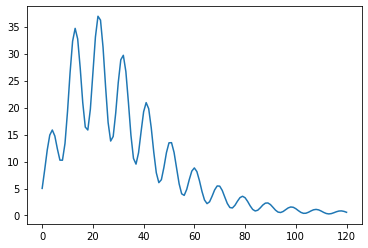

In [7]:
plt.plot(x_train[100])

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1000, random_state=0, max_iter = 40, verbose = True)
kmeans.fit(x_train)
C = kmeans.cluster_centers_

Initialization complete
Iteration 0, inertia 103518.24600506634
Iteration 1, inertia 83644.81414954805
Iteration 2, inertia 80518.89400019757
Iteration 3, inertia 79591.17164795722
Iteration 4, inertia 79270.00353651195
Iteration 5, inertia 79091.0381243086
Iteration 6, inertia 78981.31542007919
Iteration 7, inertia 78927.22891526754
Iteration 8, inertia 78900.47921558302
Iteration 9, inertia 78873.17561645892
Iteration 10, inertia 78851.11426301119
Iteration 11, inertia 78841.13519896091
Iteration 12, inertia 78831.08538880931
Iteration 13, inertia 78823.1464614519
Iteration 14, inertia 78819.18902082955
Iteration 15, inertia 78816.74561776643
Iteration 16, inertia 78814.29742962199
Iteration 17, inertia 78811.68819374271
Iteration 18, inertia 78809.97737843612
Iteration 19, inertia 78808.60933117973
Converged at iteration 19: center shift 0.0033332775154710278 within tolerance 0.00336925239468221.
Initialization complete
Iteration 0, inertia 103139.11077269584
Iteration 1, inertia 83

Iteration 24, inertia 78264.96688077133
Iteration 25, inertia 78264.49667254741
Iteration 26, inertia 78263.28871065493
Iteration 27, inertia 78262.89405712168
Converged at iteration 27: center shift 0.0006978396731511934 within tolerance 0.00336925239468221.
Initialization complete
Iteration 0, inertia 102726.28990832067
Iteration 1, inertia 82930.25275491174
Iteration 2, inertia 79810.80625671658
Iteration 3, inertia 78953.95312123993
Iteration 4, inertia 78602.30898751039
Iteration 5, inertia 78435.52114224243
Iteration 6, inertia 78345.37692265926
Iteration 7, inertia 78293.07038227333
Iteration 8, inertia 78266.5586074006
Iteration 9, inertia 78254.9920826131
Iteration 10, inertia 78250.11781606686
Iteration 11, inertia 78246.06153686301
Iteration 12, inertia 78243.53025579342
Iteration 13, inertia 78241.35679492429
Iteration 14, inertia 78238.62191514332
Iteration 15, inertia 78237.320683169
Iteration 16, inertia 78235.12292581615
Iteration 17, inertia 78232.78581921905
Iteration

In [9]:
rbf = RBF_Net()
rbf.fit(x_train, y_train, C)
y_pred = rbf.predict(x_test)

F progress: 100%|██████████████████████████| 1000/1000 [01:36<00:00, 10.31it/s]


Train complete


F progress: 100%|██████████████████████████| 1000/1000 [01:37<00:00, 10.29it/s]


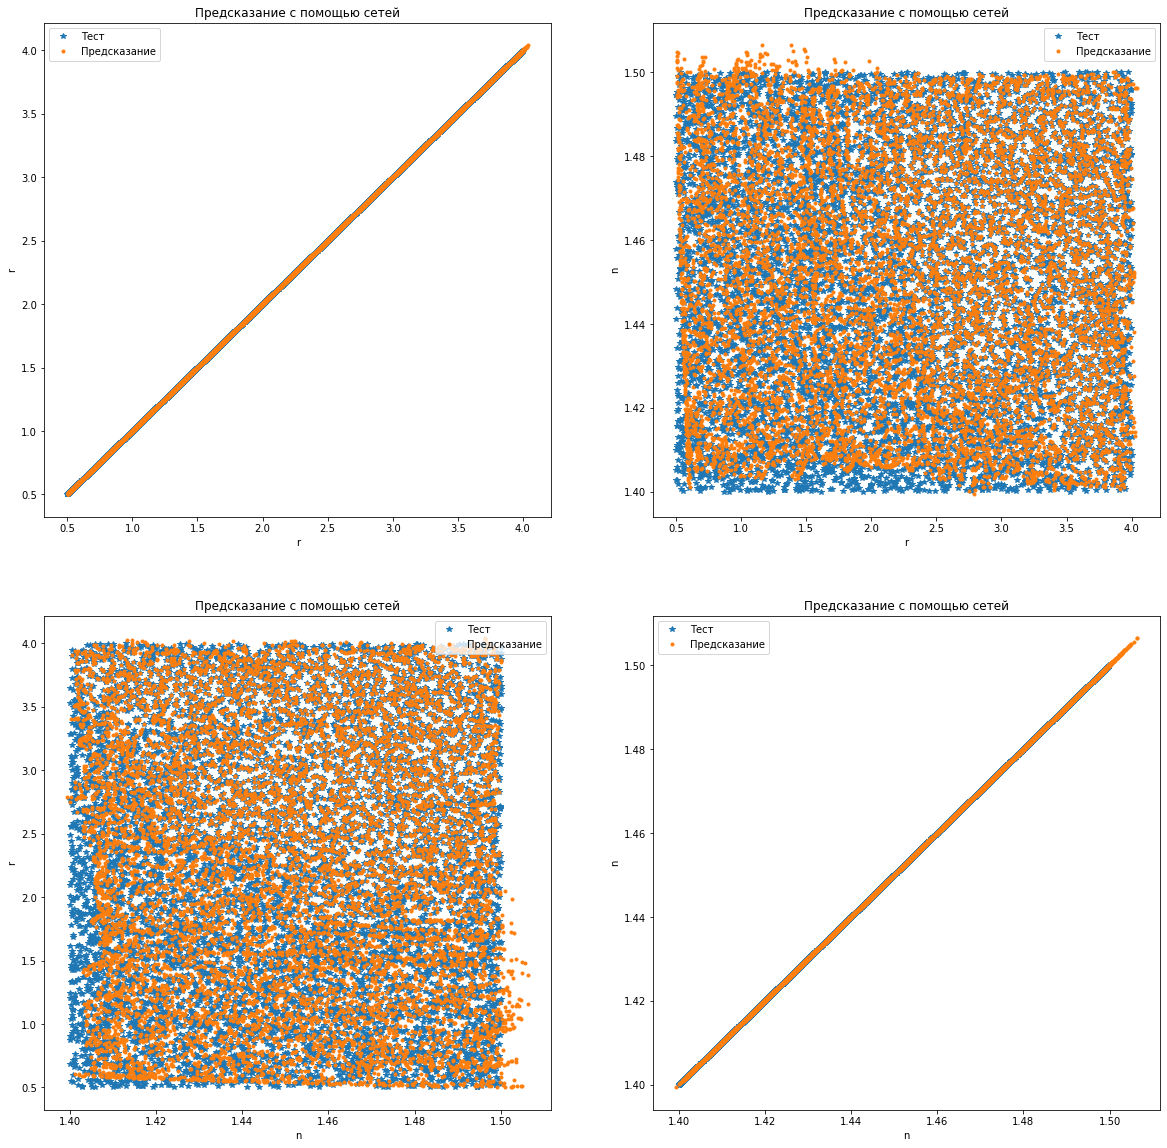

In [10]:
predict_plot(y_test, y_pred, ['r','n'])

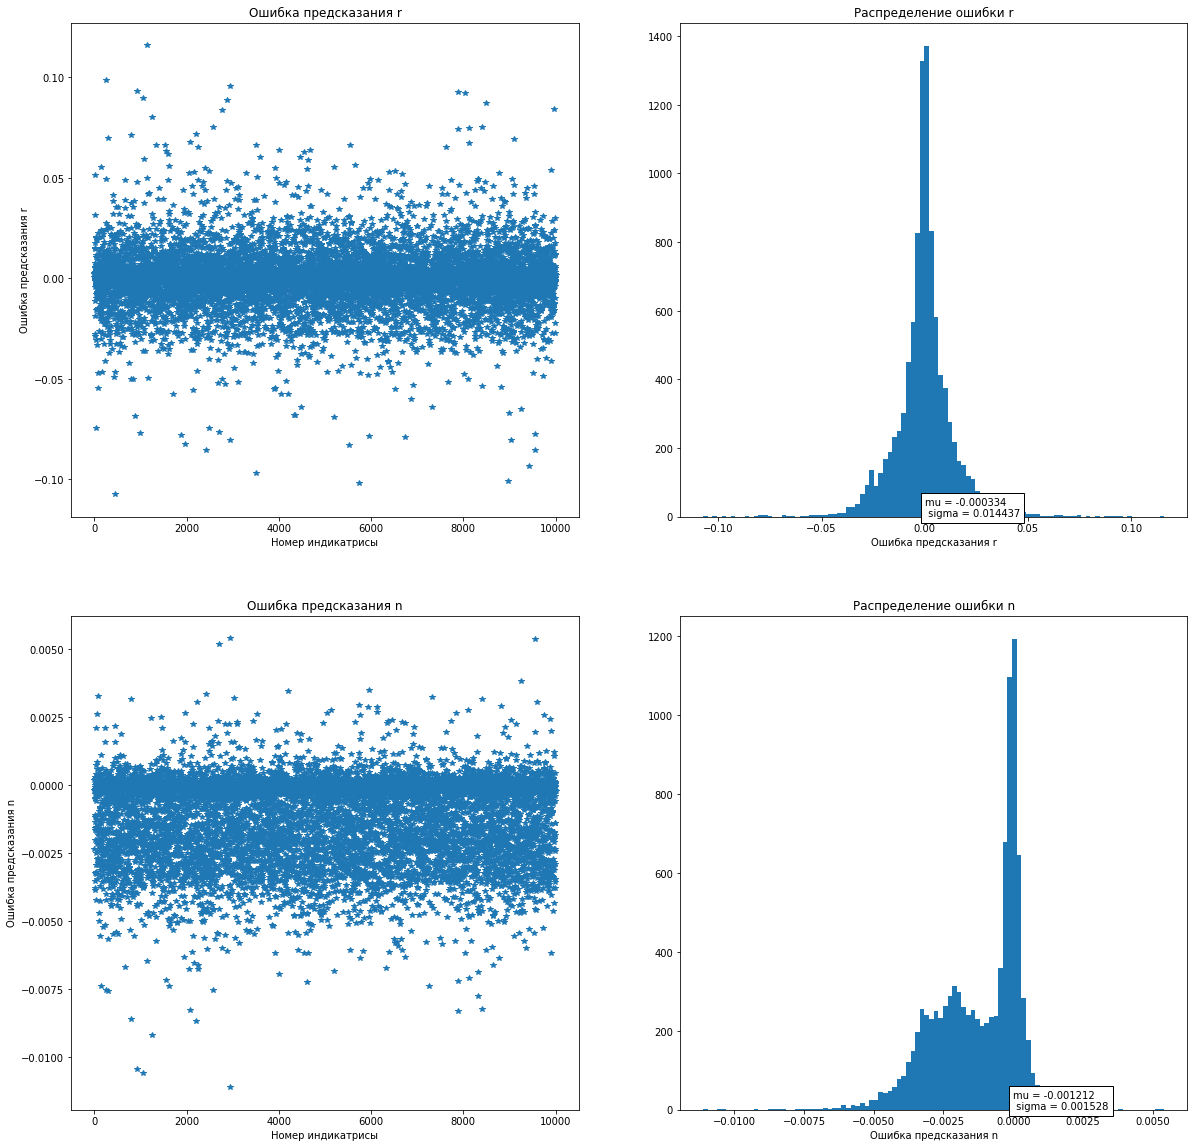

In [11]:
errors = error_plot(y_test, y_pred,['r','n'])

In [12]:
x_test_noise = np.copy(x_test)
for i in range(len(x_test_noise)):
    sigma = np.max((x_test_noise[i])) * 0.02
    for j in range(len(x_test_noise[i])):
        x_test_noise[i][j] = np.random.normal(x_test_noise[i][j], sigma)

In [13]:
y_pred_noise = rbf.predict(x_test_noise)

F progress: 100%|██████████████████████████| 1000/1000 [01:37<00:00, 10.29it/s]


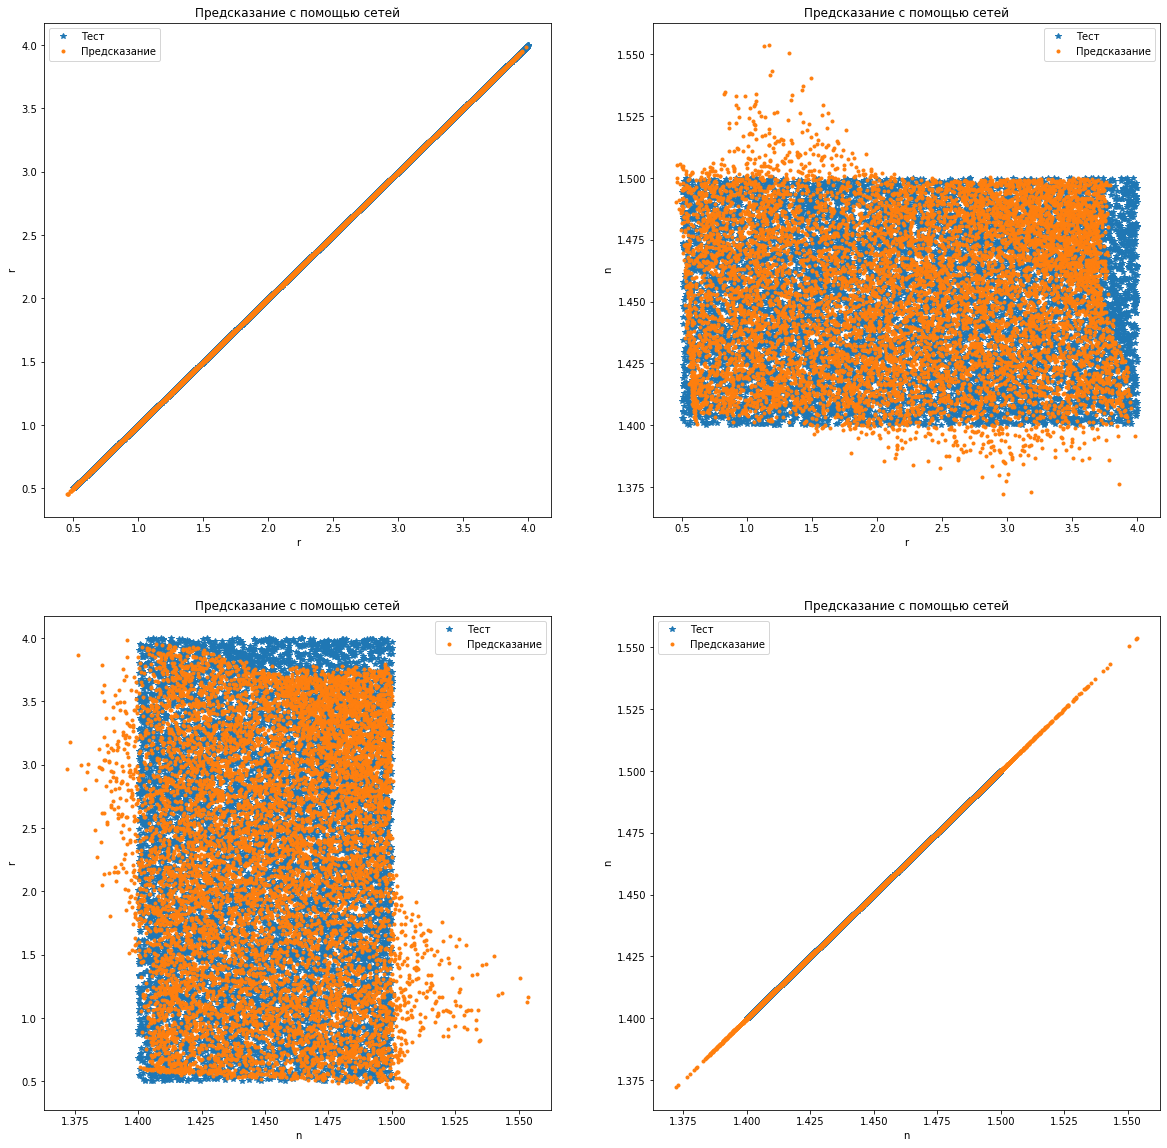

In [14]:
predict_plot(y_test, y_pred_noise, ['r','n'])

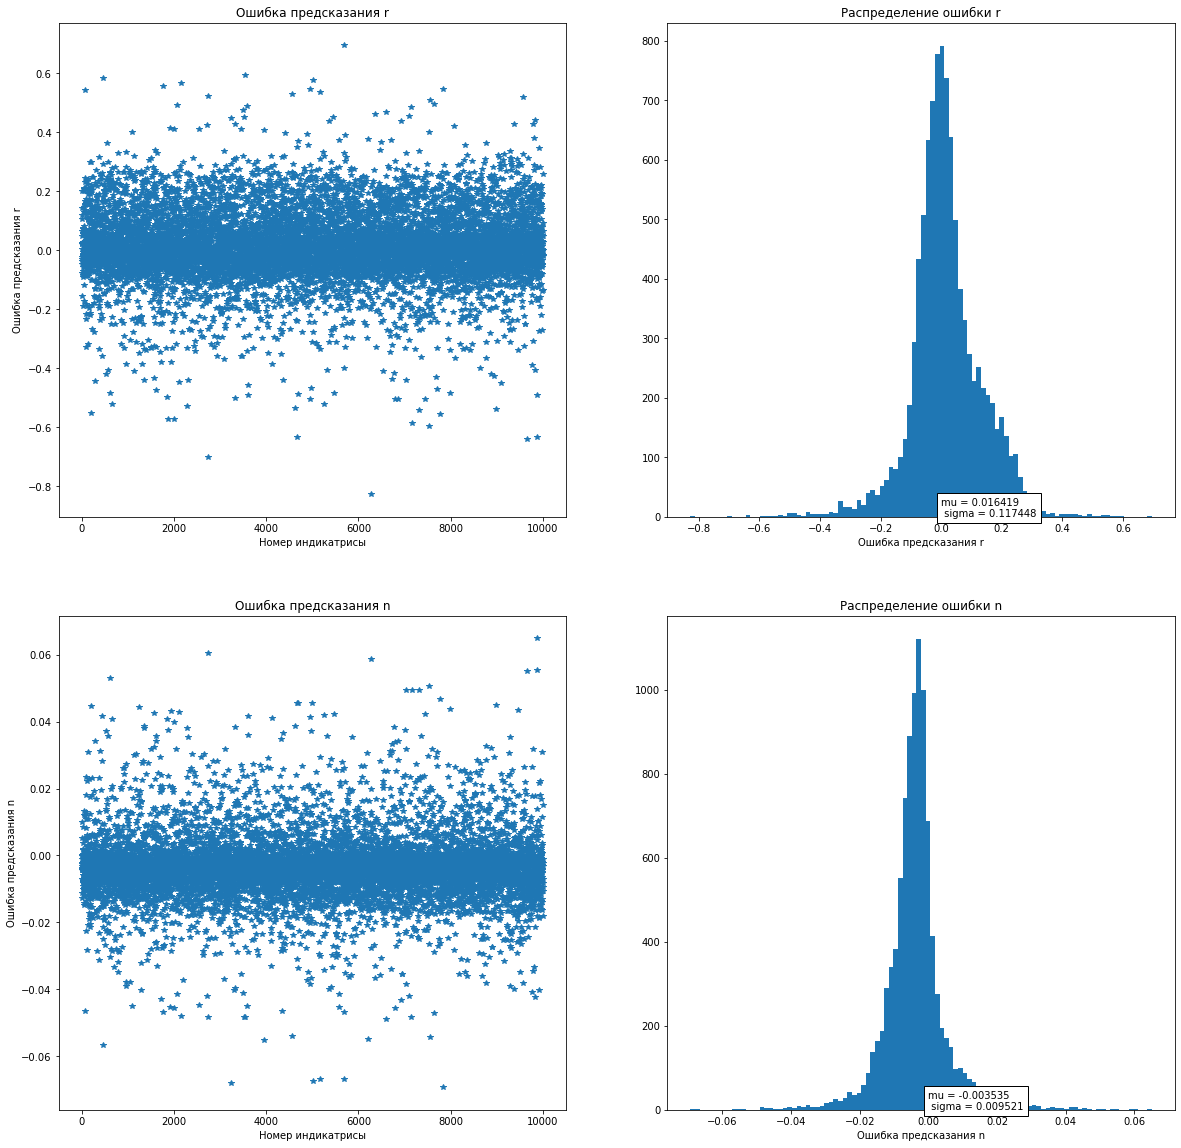

In [15]:
errors = error_plot(y_test, y_pred_noise,['r','n'])

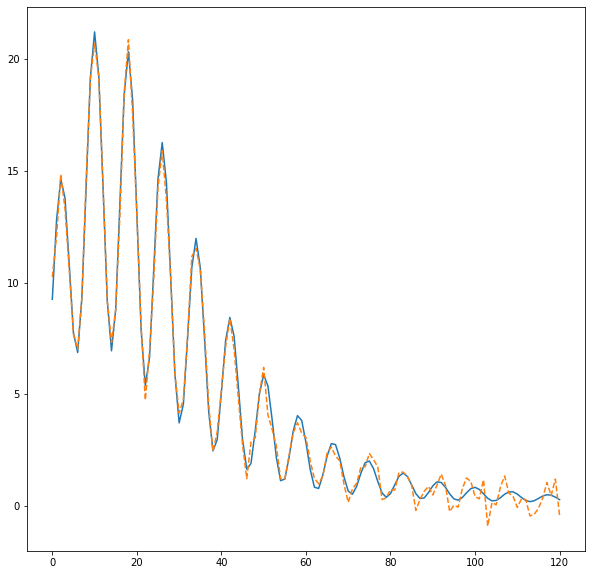

In [16]:
plt.figure(figsize=(10,10))
plt.plot(x_test[10],'-',x_test_noise[10],'--')